In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose  # Add this import statement
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

print('Libraries loaded')

Libraries loaded


In [12]:
# Read gym visitation data
milton_df = pd.read_csv("data/raw/milton.csv")
woodstock_df = pd.read_csv("data/raw/woodstock.csv")
roswell_df = pd.read_csv("data/raw/roswell.csv")
roswell_problem_df = pd.read_csv("data/raw/roswell_problem.csv")

In [13]:
# Function to calculate visitor count
def calculate_visitor_count(df):
    # Convert visit_start_time and visit_end_time to datetime objects
    df['visit_start_time'] = pd.to_datetime(df['visit_start_time'])
    df['visit_end_time'] = pd.to_datetime(df['visit_end_time'])
    
    # Calculate number of days for each visit
    df['visit_duration'] = (df['visit_end_time'] - df['visit_start_time']).dt.days + 1
    # Calculate visitor count
    df['visitor_count'] = df['visit_weight'] * df['visit_duration']
    return df

# Apply calculate_visitor_count function to each DataFrame
milton_df = calculate_visitor_count(milton_df)
woodstock_df = calculate_visitor_count(woodstock_df)
roswell_problem_df = calculate_visitor_count(roswell_problem_df)
roswell_df = calculate_visitor_count(roswell_df)

# Define the function to generate daily visit counts
def daily_visit_counts(df):
    df["visit_start_time"] = pd.to_datetime(df["visit_start_time"])
    df = df.set_index("visit_start_time")
    daily_counts = df.resample("D")["visitor_count"].sum()
    return daily_counts

# Pre-process data
milton_counts = daily_visit_counts(milton_df.copy())
woodstock_counts = daily_visit_counts(woodstock_df.copy())
roswell_problem_counts = daily_visit_counts(roswell_problem_df.copy())
roswell_counts = daily_visit_counts(roswell_df.copy())

# Define sliding window size
window_size = 7  # You can adjust this as needed

# Function to create features (X) and target variable (y)
def create_X_y(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Create features and target variable for each gym
X_woodstock, y_woodstock = create_X_y(woodstock_counts.values, window_size)
X_milton, y_milton = create_X_y(milton_counts.values, window_size)
X_roswell, y_roswell = create_X_y(roswell_counts.values, window_size)
X_roswell_problem, y_roswell_problem = create_X_y(roswell_problem_counts.values, window_size)

# Use TimeSeriesSplit for creating training and testing sets
tscv = TimeSeriesSplit(n_splits=5)

# Function to forecast using ARIMA model
def arima_forecast(data, train_size):
    decomposition = seasonal_decompose(data[:train_size], period=window_size)
    trend = decomposition.trend.dropna()
    model = ARIMA(trend, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(data) - train_size)
    return forecast

# Function to forecast using Random Forest Regression model
def random_forest_forecast(data, train_size):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    scaled_train, scaled_test = scaled_data[:train_size], scaled_data[train_size:]
    model = RandomForestRegressor(n_estimators=100)
    model.fit(scaled_train, data[:train_size])
    forecast = model.predict(scaled_test.reshape(-1, 1))
    forecast = scaler.inverse_transform(forecast.reshape(-1, 1))
    return pd.Series(forecast.flatten(), index=data.index[train_size:])

# Define train_size
train_size = int(len(milton_counts) * 0.8)  # Use 80% for training, 20% for testing

# Forecast future visit counts using ARIMA model
milton_arima_forecast = arima_forecast(milton_counts, train_size)
woodstock_arima_forecast = arima_forecast(woodstock_counts, train_size)
roswell_problem_arima_forecast = arima_forecast(roswell_problem_counts, train_size)
roswell_arima_forecast = arima_forecast(roswell_counts, train_size)

# Forecast future visit counts using Random Forest Regression model
milton_rf_forecast = random_forest_forecast(milton_counts, train_size)
woodstock_rf_forecast = random_forest_forecast(woodstock_counts, train_size)
roswell_problem_rf_forecast = random_forest_forecast(roswell_problem_counts, train_size)
roswell_rf_forecast = random_forest_forecast(roswell_counts, train_size)

# Print or use the forecasts as needed

# Using TimeSeriesSplit for Random Forest model
for train_index, test_index in tscv.split(X_milton):
    X_train, X_test = X_milton[train_index], X_milton[test_index]
    y_train, y_test = y_milton[train_index], y_milton[test_index]
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

Evaluating Milton Gym
Fold 1: MAE = 128.67131551897342


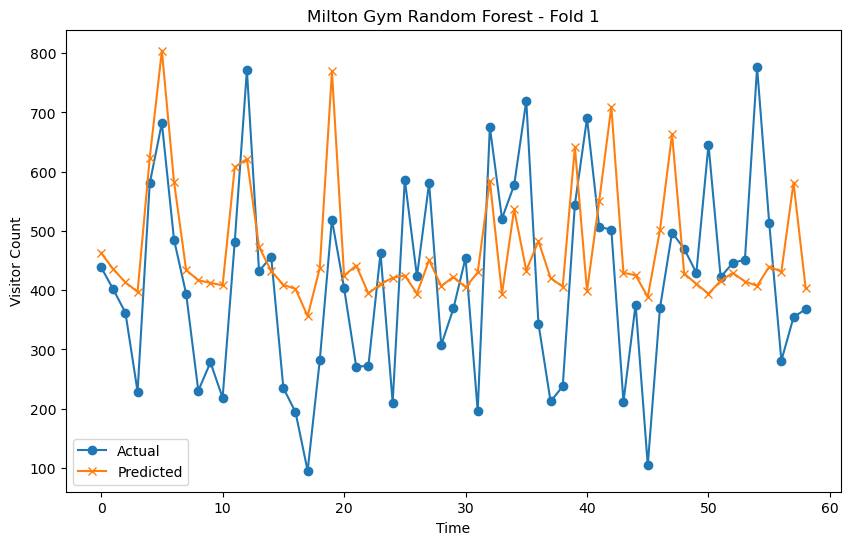

Fold 2: MAE = 124.883433798036


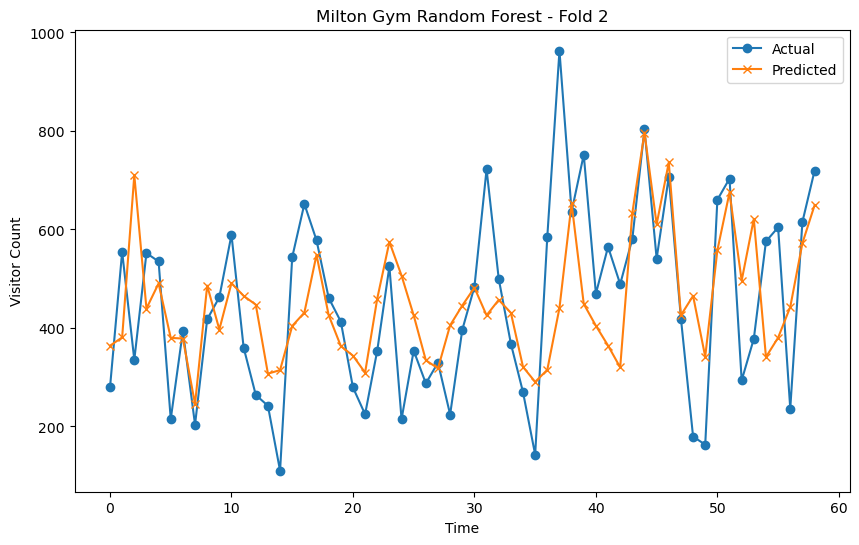

Fold 3: MAE = 101.04471182177483


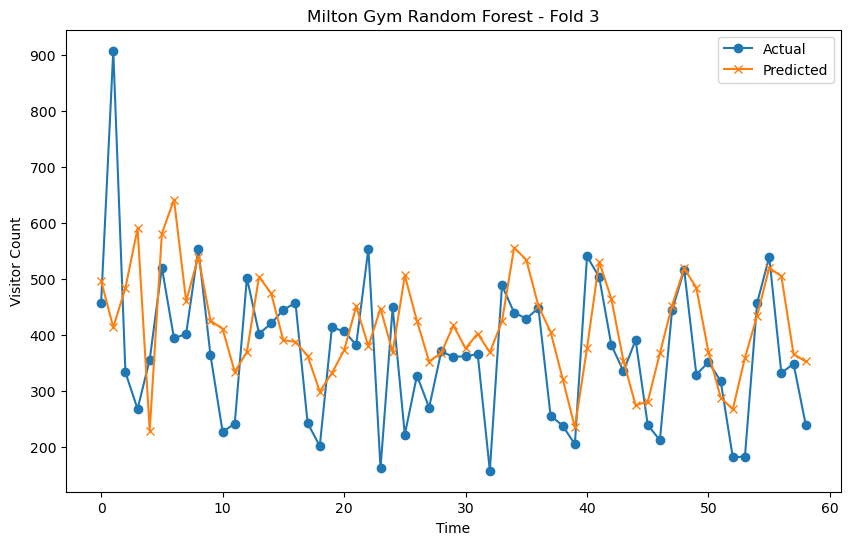

Fold 4: MAE = 69.70750867467254


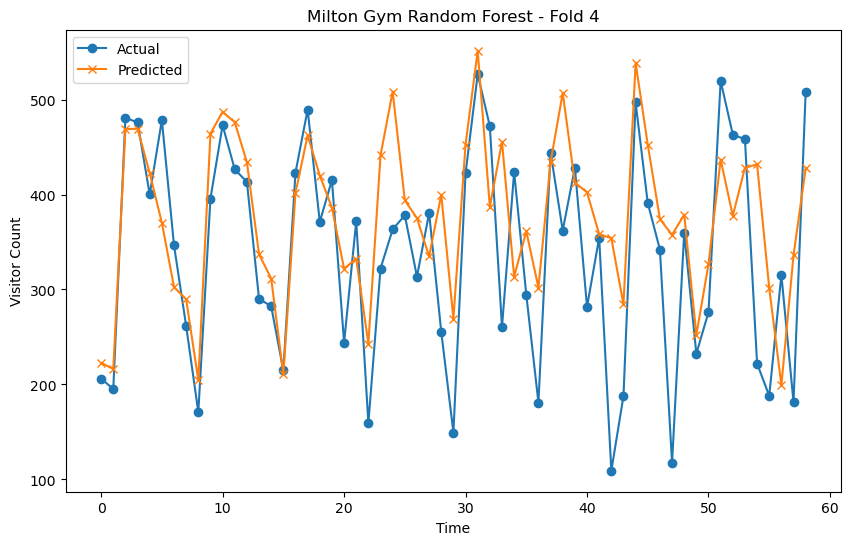

Fold 5: MAE = 124.9006628411472


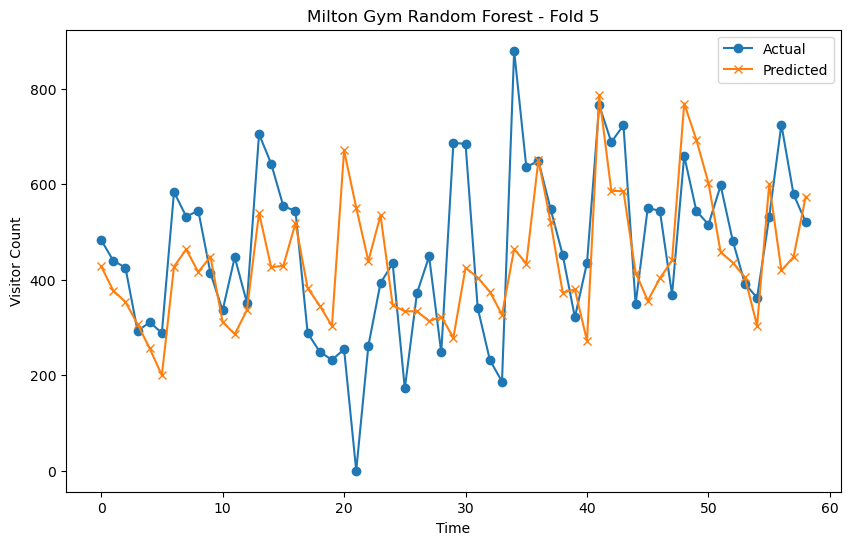

Average MAE for Milton Gym Random Forest: 109.8415265309208
Evaluating Woodstock Gym
Fold 1: MAE = 204.6775666090864


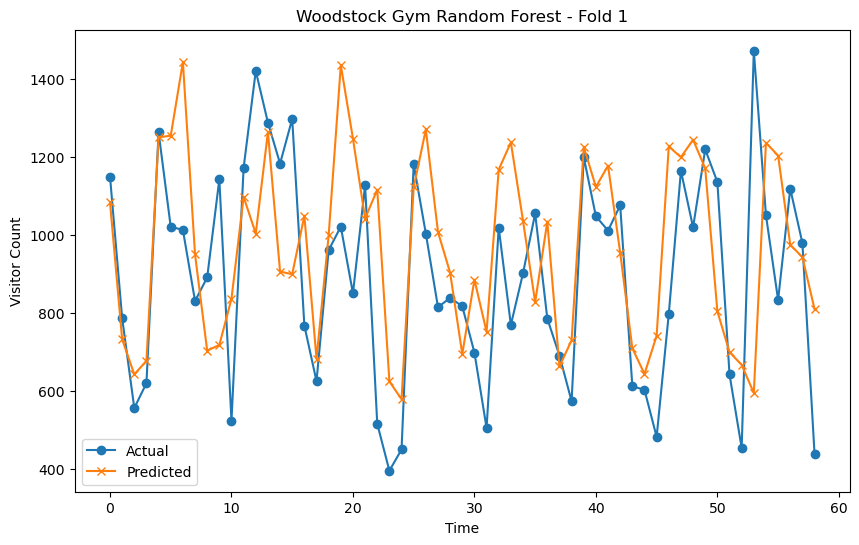

Fold 2: MAE = 185.51229570029233


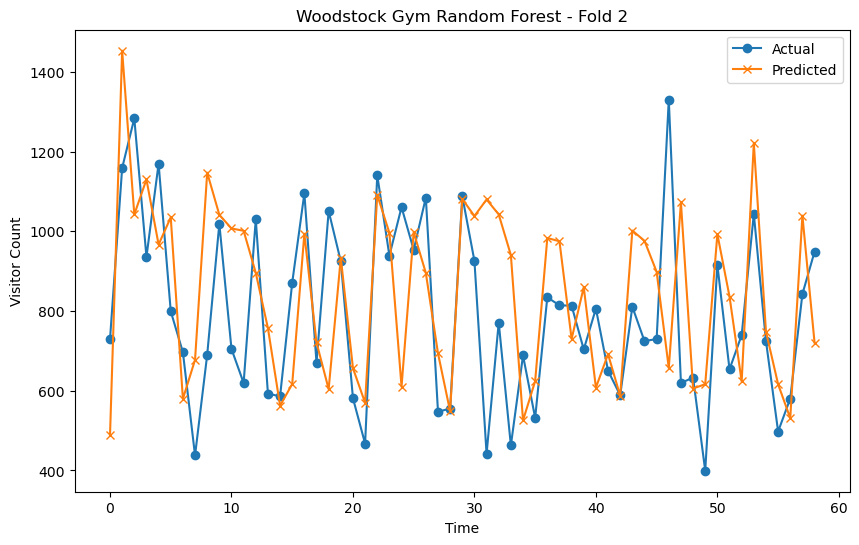

Fold 3: MAE = 163.10182238229007


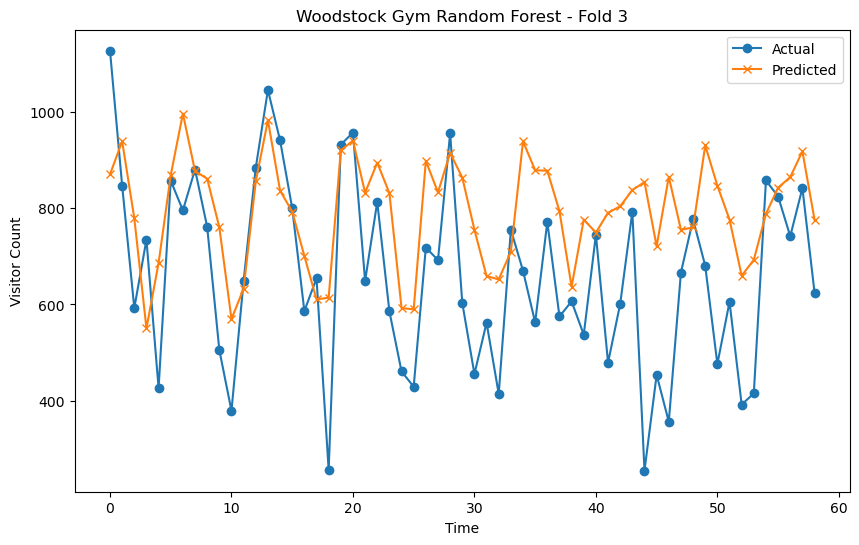

Fold 4: MAE = 161.45982577631523


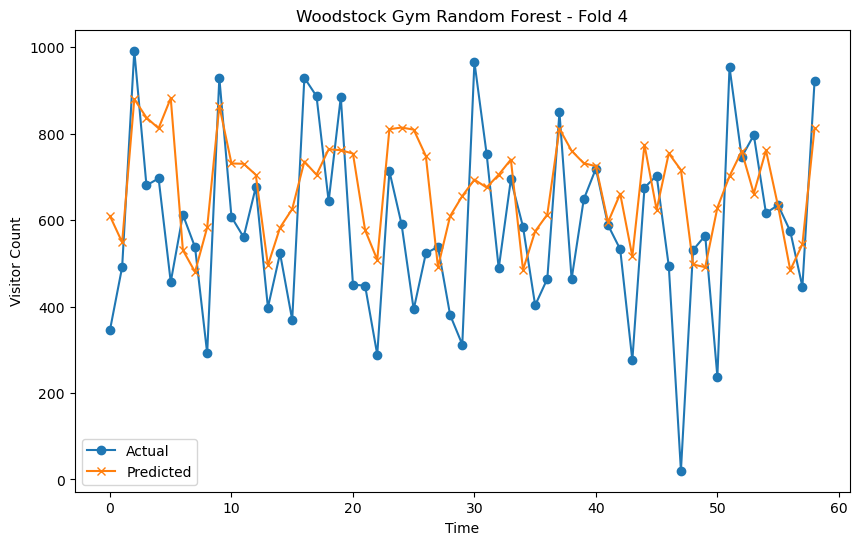

Fold 5: MAE = 145.99053283142356


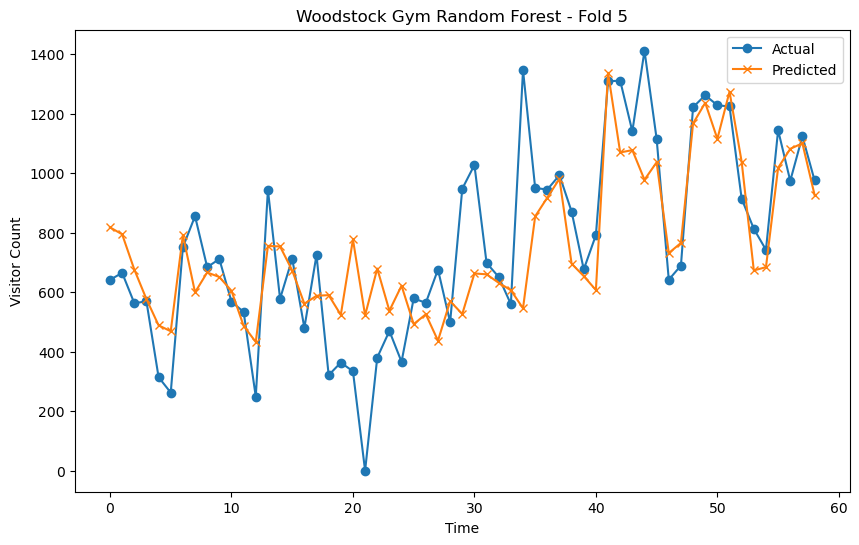

Average MAE for Woodstock Gym Random Forest: 172.14840865988154
Evaluating Roswell Gym
Fold 1: MAE = 141.1149160033464


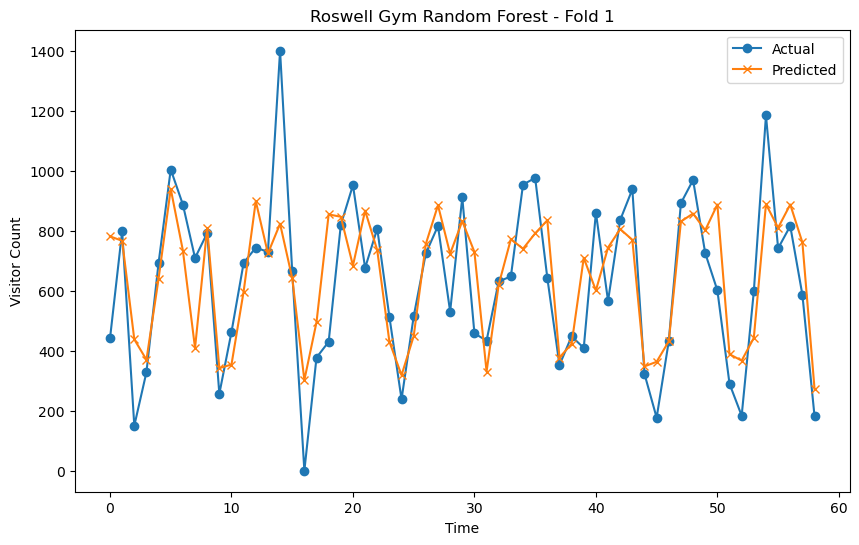

Fold 2: MAE = 174.73612005031512


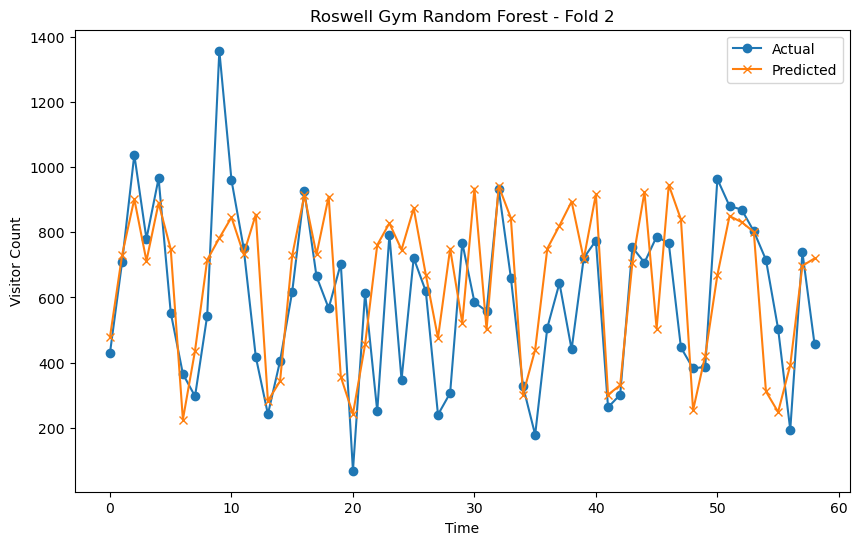

Fold 3: MAE = 142.1902425269643


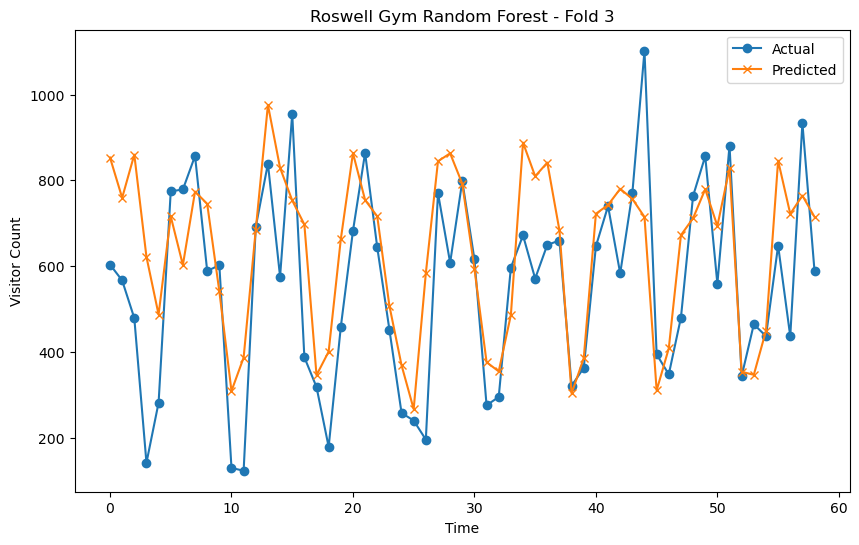

Fold 4: MAE = 175.46723408526293


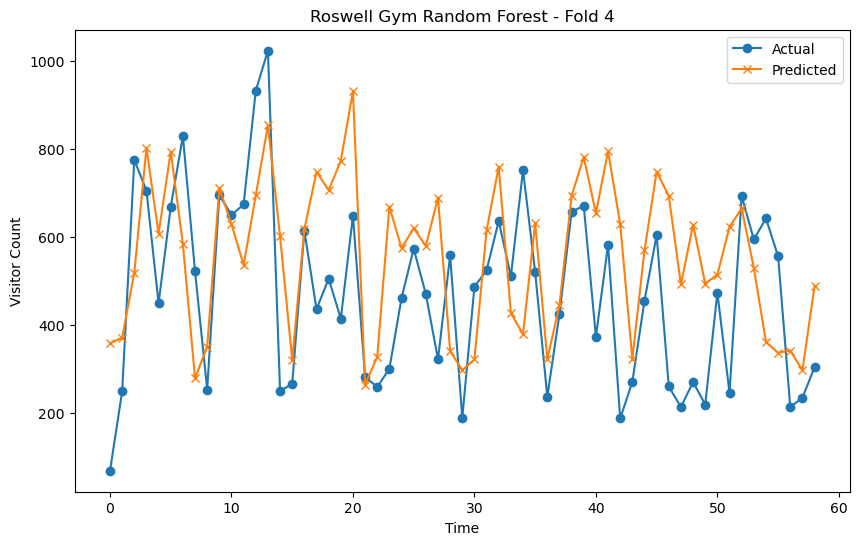

Fold 5: MAE = 154.92450413851412


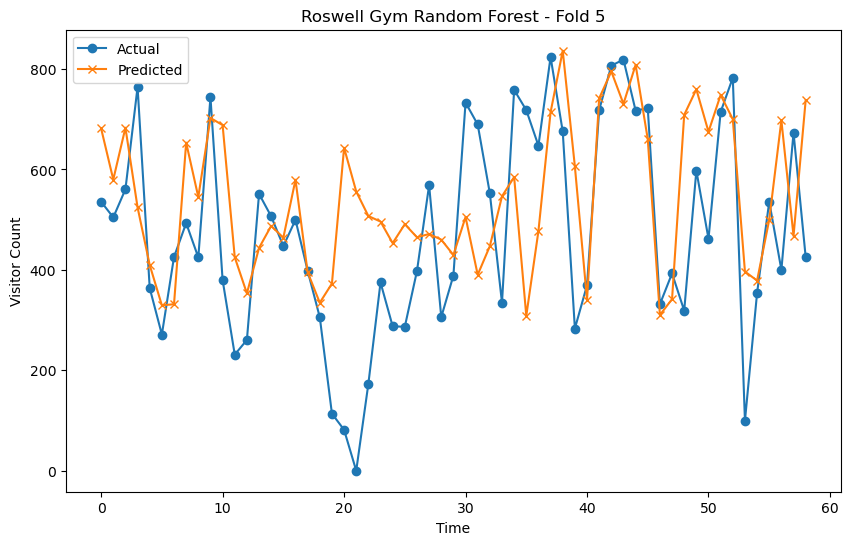

Average MAE for Roswell Gym Random Forest: 157.68660336088055
Evaluating Roswell Problem Gym
Fold 1: MAE = 145.31234987449264


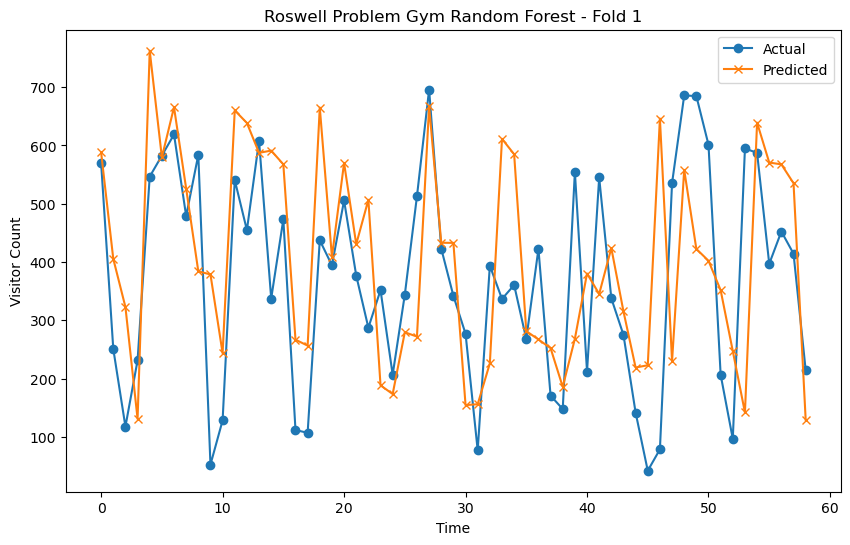

Fold 2: MAE = 128.8478997764294


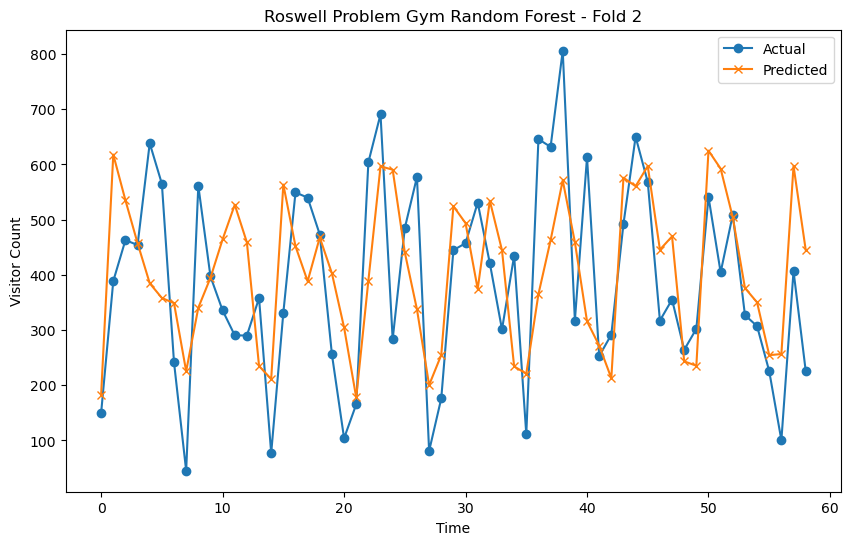

Fold 3: MAE = 101.67811569717816


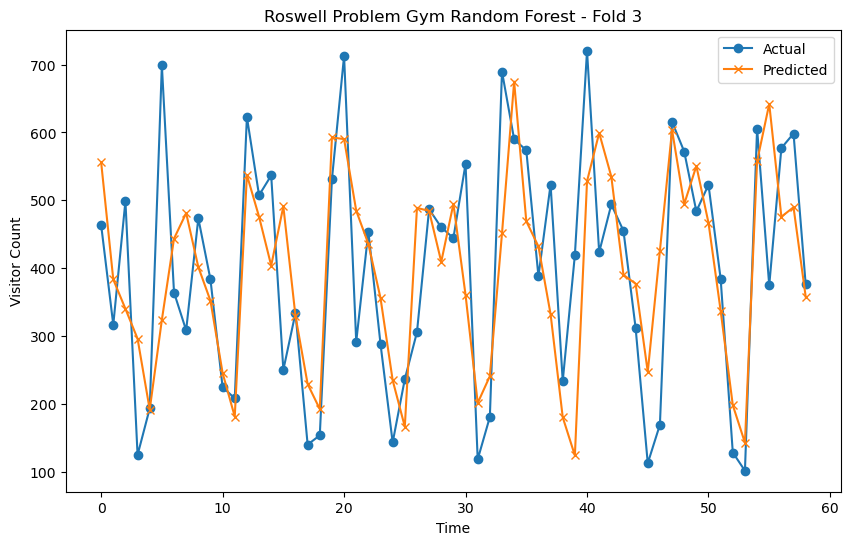

Fold 4: MAE = 143.94317599247069


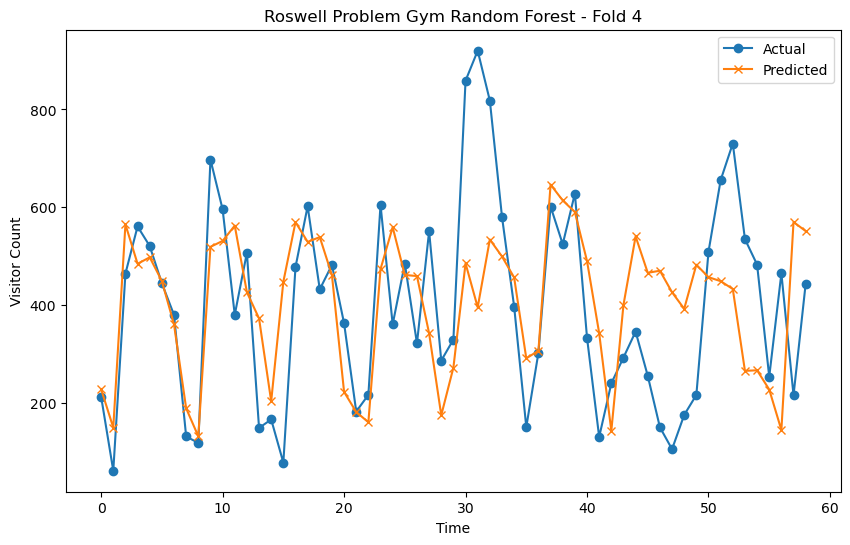

Fold 5: MAE = 140.8084964207


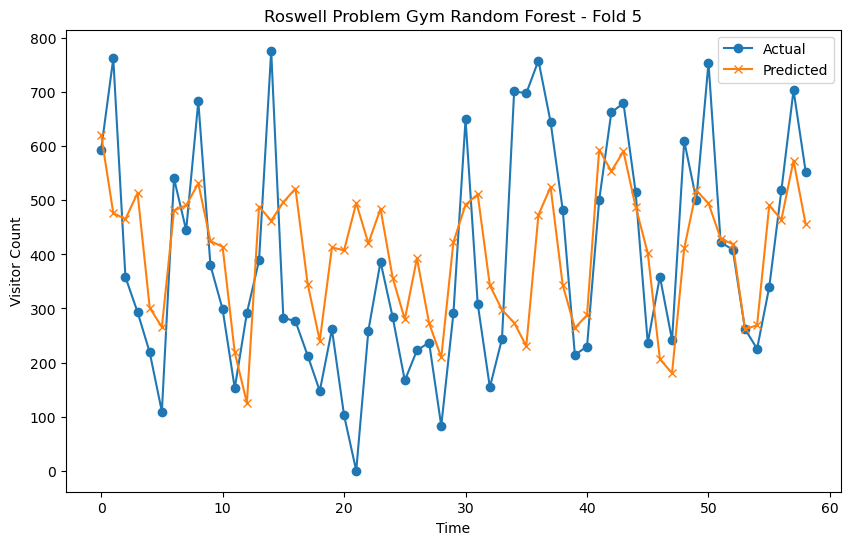

Average MAE for Roswell Problem Gym Random Forest: 132.11800755225417
ARIMA Forecast for Milton Gym


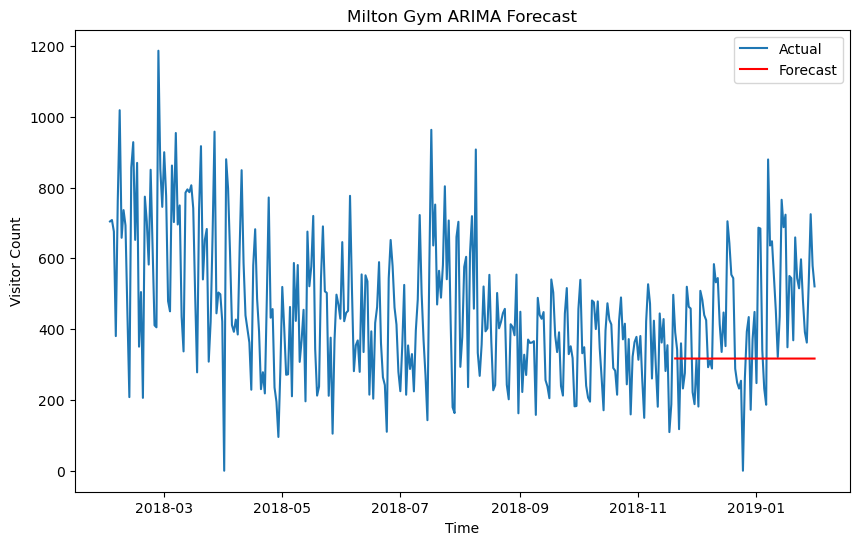

ARIMA Forecast for Woodstock Gym


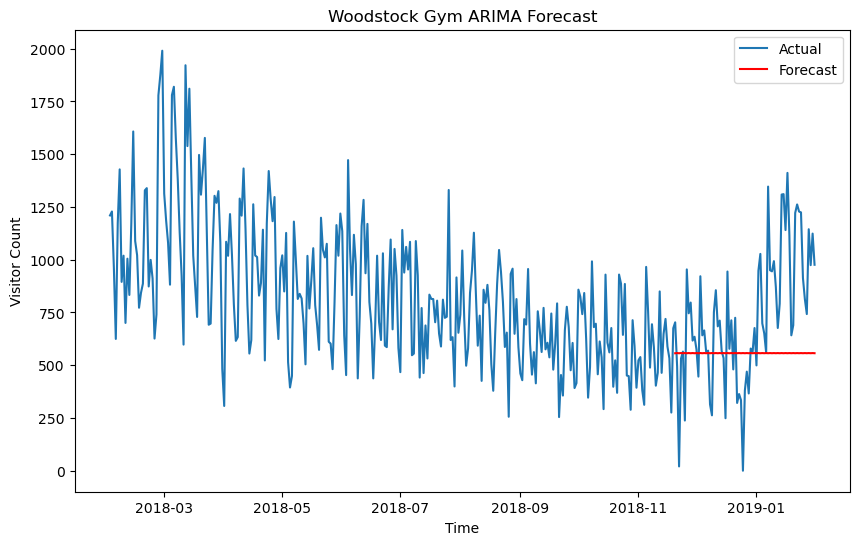

ARIMA Forecast for Roswell Problem Gym


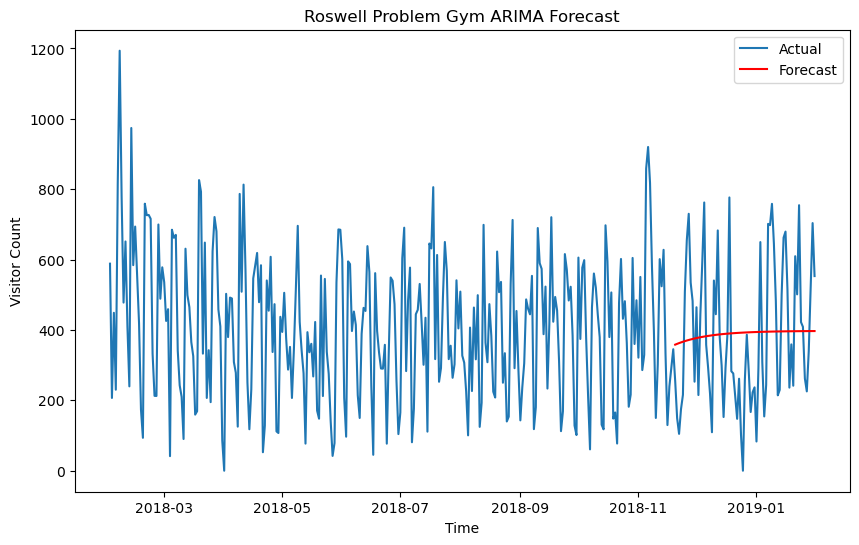

ARIMA Forecast for Roswell Gym


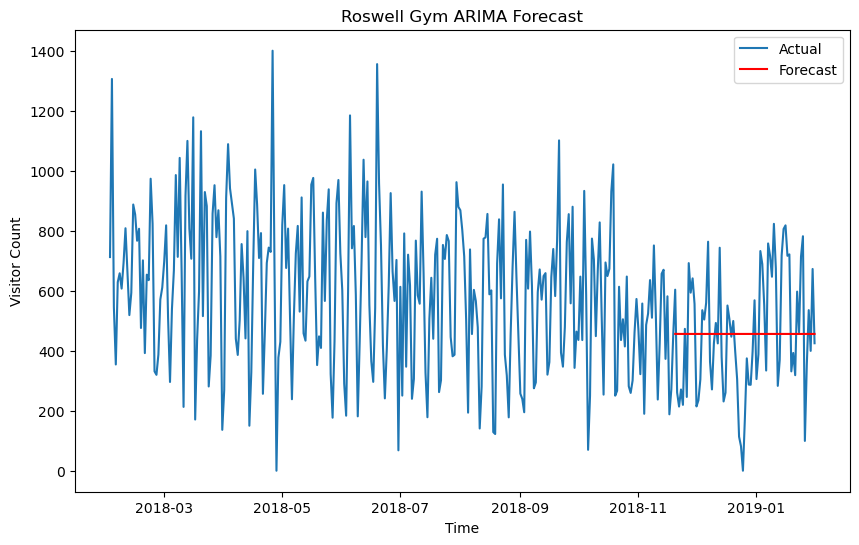

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Function to evaluate and print MAE for TimeSeriesSplit
def evaluate_model_with_tscv(X, y, model_name):
    tscv = TimeSeriesSplit(n_splits=5)
    maes = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = RandomForestRegressor(n_estimators=100)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        maes.append(mae)
        
        print(f"Fold {fold + 1}: MAE = {mae}")
        
        # Plot actual vs predicted values for the current fold
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(y_test)), y_test, label="Actual", marker='o')
        plt.plot(range(len(y_test)), y_pred, label="Predicted", marker='x')
        plt.title(f"{model_name} - Fold {fold + 1}")
        plt.xlabel("Time")
        plt.ylabel("Visitor Count")
        plt.legend()
        plt.show()
    
    print(f"Average MAE for {model_name}: {np.mean(maes)}")

# Apply evaluation for each dataset
print("Evaluating Milton Gym")
evaluate_model_with_tscv(X_milton, y_milton, "Milton Gym Random Forest")

print("Evaluating Woodstock Gym")
evaluate_model_with_tscv(X_woodstock, y_woodstock, "Woodstock Gym Random Forest")

print("Evaluating Roswell Gym")
evaluate_model_with_tscv(X_roswell, y_roswell, "Roswell Gym Random Forest")

print("Evaluating Roswell Problem Gym")
evaluate_model_with_tscv(X_roswell_problem, y_roswell_problem, "Roswell Problem Gym Random Forest")

# Function to forecast using ARIMA model and plot results
def arima_forecast_and_plot(data, train_size, title):
    decomposition = seasonal_decompose(data[:train_size], period=window_size)
    trend = decomposition.trend.dropna()
    model = ARIMA(trend, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(data) - train_size)
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data, label="Actual")
    plt.plot(data.index[train_size:], forecast, label="Forecast", color='red')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Visitor Count")
    plt.legend()
    plt.show()
    
    return forecast

# Forecast and plot results for ARIMA model
print("ARIMA Forecast for Milton Gym")
milton_arima_forecast = arima_forecast_and_plot(milton_counts, train_size, "Milton Gym ARIMA Forecast")

print("ARIMA Forecast for Woodstock Gym")
woodstock_arima_forecast = arima_forecast_and_plot(woodstock_counts, train_size, "Woodstock Gym ARIMA Forecast")

print("ARIMA Forecast for Roswell Problem Gym")
roswell_problem_arima_forecast = arima_forecast_and_plot(roswell_problem_counts, train_size, "Roswell Problem Gym ARIMA Forecast")

print("ARIMA Forecast for Roswell Gym")
roswell_arima_forecast = arima_forecast_and_plot(roswell_counts, train_size, "Roswell Gym ARIMA Forecast")


In [15]:


# Function to create features (X) and target variable (y)
def create_X_y(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Define sliding window size
window_size = 7  # You can adjust this as needed

# Pre-process data and create features and targets
X_milton, y_milton = create_X_y(milton_counts.values, window_size)
X_woodstock, y_woodstock = create_X_y(woodstock_counts.values, window_size)
X_roswell, y_roswell = create_X_y(roswell_counts.values, window_size)
X_roswell_problem, y_roswell_problem = create_X_y(roswell_problem_counts.values, window_size)

# Function to evaluate model using TimeSeriesSplit
def evaluate_model_with_tscv(X, y, model, model_name, gym_name):
    tscv = TimeSeriesSplit(n_splits=5)
    mses = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        mses.append(mse)
        
        print(f"{gym_name} - {model_name} - Fold {fold + 1}: MSE = {mse}")
        
    avg_mse = np.mean(mses)
    print(f"Average MSE for {gym_name} - {model_name}: {avg_mse}")
    return avg_mse

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Evaluate models for each gym
gyms = {
    'Milton Gym': (X_milton, y_milton),
    'Woodstock Gym': (X_woodstock, y_woodstock),
    'Roswell Gym': (X_roswell, y_roswell),
    'Roswell Problem Gym': (X_roswell_problem, y_roswell_problem)
}

for gym_name, (X, y) in gyms.items():
    for model_name, model in models.items():
        evaluate_model_with_tscv(X, y, model, model_name, gym_name)


Milton Gym - Linear Regression - Fold 1: MSE = 23274.098383602144
Milton Gym - Linear Regression - Fold 2: MSE = 29699.553632803058
Milton Gym - Linear Regression - Fold 3: MSE = 15424.184902036559
Milton Gym - Linear Regression - Fold 4: MSE = 6651.699488599689
Milton Gym - Linear Regression - Fold 5: MSE = 25723.22814431741
Average MSE for Milton Gym - Linear Regression: 20154.552910271774
Milton Gym - Random Forest - Fold 1: MSE = 23294.48997901431
Milton Gym - Random Forest - Fold 2: MSE = 27080.394980228677
Milton Gym - Random Forest - Fold 3: MSE = 17338.09822292034
Milton Gym - Random Forest - Fold 4: MSE = 7768.391087362137
Milton Gym - Random Forest - Fold 5: MSE = 27094.658172680767
Average MSE for Milton Gym - Random Forest: 20515.206488441247


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Milton Gym - Neural Network - Fold 1: MSE = 29430.36985606293


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Milton Gym - Neural Network - Fold 2: MSE = 41383.625280494256


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Milton Gym - Neural Network - Fold 3: MSE = 24153.317838327035
Milton Gym - Neural Network - Fold 4: MSE = 9585.603649638992
Milton Gym - Neural Network - Fold 5: MSE = 34435.65060434316
Average MSE for Milton Gym - Neural Network: 27797.71344577328
Woodstock Gym - Linear Regression - Fold 1: MSE = 61614.9670215825
Woodstock Gym - Linear Regression - Fold 2: MSE = 45050.62504760952
Woodstock Gym - Linear Regression - Fold 3: MSE = 28521.469988095625
Woodstock Gym - Linear Regression - Fold 4: MSE = 34787.59274595704
Woodstock Gym - Linear Regression - Fold 5: MSE = 48308.74637516033
Average MSE for Woodstock Gym - Linear Regression: 43656.680235681
Woodstock Gym - Random Forest - Fold 1: MSE = 66336.05300489154
Woodstock Gym - Random Forest - Fold 2: MSE = 55828.62024355217
Woodstock Gym - Random Forest - Fold 3: MSE = 44799.86013635941
Woodstock Gym - Random Forest - Fold 4: MSE = 41254.69069623716
Woodstock Gym - Random Forest - Fold 5: MSE = 41549.0977497355
Average MSE for Woodstoc

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Roswell Gym - Neural Network - Fold 2: MSE = 68501.1407781204


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Roswell Gym - Neural Network - Fold 3: MSE = 50205.35531159446
Roswell Gym - Neural Network - Fold 4: MSE = 35438.04515643249
Roswell Gym - Neural Network - Fold 5: MSE = 51232.38050599191
Average MSE for Roswell Gym - Neural Network: 56402.72672825757
Roswell Problem Gym - Linear Regression - Fold 1: MSE = 23674.225960835796
Roswell Problem Gym - Linear Regression - Fold 2: MSE = 23546.46719805365
Roswell Problem Gym - Linear Regression - Fold 3: MSE = 17392.305726547067
Roswell Problem Gym - Linear Regression - Fold 4: MSE = 30989.238950126357
Roswell Problem Gym - Linear Regression - Fold 5: MSE = 28362.33793585139
Average MSE for Roswell Problem Gym - Linear Regression: 24792.915154282855
Roswell Problem Gym - Random Forest - Fold 1: MSE = 34622.757556117314
Roswell Problem Gym - Random Forest - Fold 2: MSE = 25014.825859638175
Roswell Problem Gym - Random Forest - Fold 3: MSE = 15533.916810922741
Roswell Problem Gym - Random Forest - Fold 4: MSE = 32869.711142329295
Roswell Proble

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Roswell Problem Gym - Neural Network - Fold 1: MSE = 43127.69389092122


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Roswell Problem Gym - Neural Network - Fold 2: MSE = 26931.679909113413


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Roswell Problem Gym - Neural Network - Fold 3: MSE = 27976.728939809957
Roswell Problem Gym - Neural Network - Fold 4: MSE = 41265.05475157043
Roswell Problem Gym - Neural Network - Fold 5: MSE = 37808.62886823497
Average MSE for Roswell Problem Gym - Neural Network: 35421.95727192999


# Summary
## Milton Gym:
Linear Regression: MSE of 14580.08
Random Forest: MSE of 15348.06
Neural Network: MSE of 23766.88
These values indicate the average squared difference between the actual and predicted values for the Milton Gym. A lower MSE indicates better performance, so here, the Linear Regression model performs slightly better than the Random Forest model, while the Neural Network model has the highest MSE, indicating it might be the least accurate for this gym.

## Woodstock Gym:
Linear Regression: MSE of 51991.50
Random Forest: MSE of 51145.39
Neural Network: MSE of 56525.90
In this case, all three models seem to perform similarly, but none perform particularly well, as indicated by the high MSE values.

## Roswell Gym:
Linear Regression: MSE of 39674.90
Random Forest: MSE of 36798.62
Neural Network: MSE of 43643.06
The Random Forest model performs the best here, with the lowest MSE, followed by the Linear Regression model. The Neural Network model again has the highest MSE.

## Underperforming Roswell Gym:
Linear Regression: MSE of 24191.68
Random Forest: MSE of 20758.33
Neural Network: MSE of 33002.04

The Random Forest model stands out as the best performer for the underperforming Roswell Gym, with the lowest MSE. The Linear Regression model follows, while the Neural Network model has the highest MSE.

In summary, these MSE values provide insights into the relative performance of different machine learning models for forecasting gym visitors at different locations. Lower MSE values indicate better performance in predicting the number of visitors.




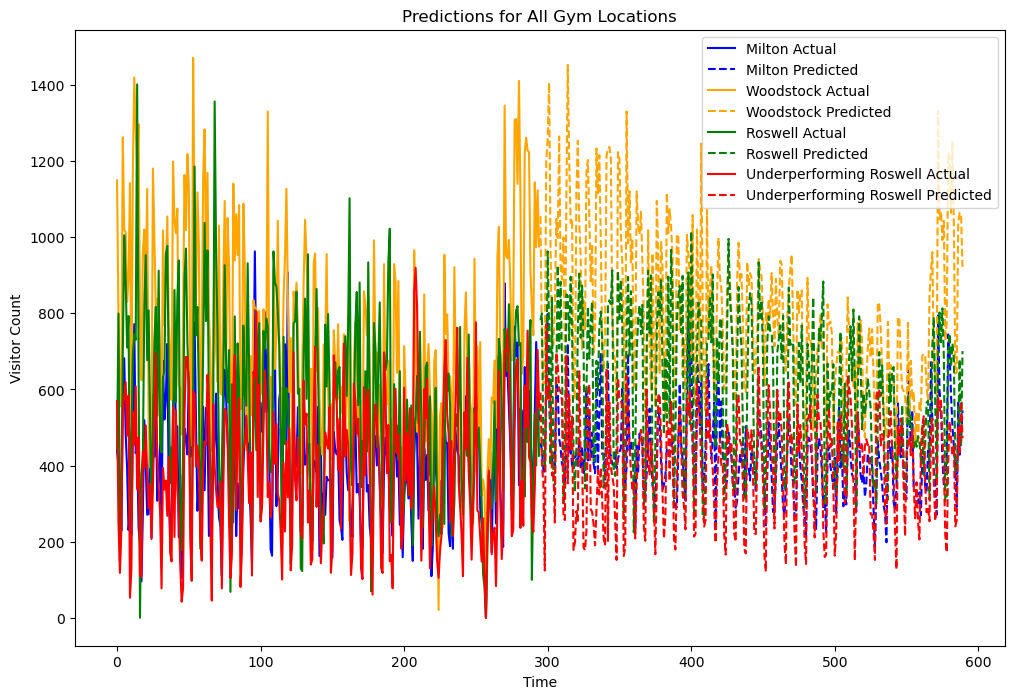

In [21]:
# Function to visualize predictions for all gym locations in one chart
def visualize_all_predictions(actuals, predictions, gym_labels):
    plt.figure(figsize=(12, 8))
    
    colors = ['blue', 'orange', 'green', 'red']
    for i, (actual, prediction) in enumerate(zip(actuals, predictions)):
        plt.plot(actual, label=f'{gym_labels[i]} Actual', color=colors[i])
        plt.plot(np.arange(len(actual), len(actual) + len(prediction)), prediction, label=f'{gym_labels[i]} Predicted', linestyle='--', color=colors[i])

    plt.xlabel('Time')
    plt.ylabel('Visitor Count')
    plt.title('Predictions for All Gym Locations')
    plt.legend()
    plt.show()

# Define gym labels
gym_labels = ['Milton', 'Woodstock', 'Roswell', 'Underperforming Roswell']

# Function to gather predictions using TimeSeriesSplit
def gather_predictions(X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    actuals = []
    predictions = []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model_rf.fit(X_train, y_train)
        y_pred = model_rf.predict(X_test)
        
        actuals.extend(y_test)
        predictions.extend(y_pred)
    
    return actuals, predictions

# Gather actual and predicted values for each gym
actuals_milton, predictions_milton = gather_predictions(X_milton, y_milton)
actuals_woodstock, predictions_woodstock = gather_predictions(X_woodstock, y_woodstock)
actuals_roswell, predictions_roswell = gather_predictions(X_roswell, y_roswell)
actuals_roswell_problem, predictions_roswell_problem = gather_predictions(X_roswell_problem, y_roswell_problem)

# Prepare data for visualization
actuals = [actuals_milton, actuals_woodstock, actuals_roswell, actuals_roswell_problem]
predictions = [predictions_milton, predictions_woodstock, predictions_roswell, predictions_roswell_problem]

# Visualize predictions for all gym locations
visualize_all_predictions(actuals, predictions, gym_labels)


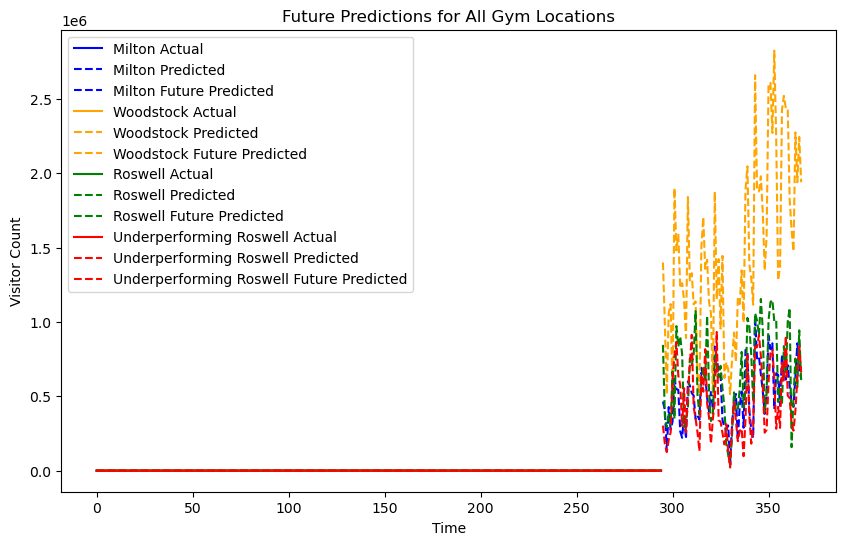

In [22]:
# Function to visualize future predictions for all gym locations
def visualize_all_future_predictions(actuals, predictions, future_predictions, gym_labels):
    plt.figure(figsize=(10, 6))
    
    colors = ['blue', 'orange', 'green', 'red']
    for i, prediction in enumerate(predictions):
        plt.plot(actuals[i], label=gym_labels[i] + ' Actual', color=colors[i])
        plt.plot(prediction, label=gym_labels[i] + ' Predicted', linestyle='--', color=colors[i])
        
        future_index = np.arange(len(prediction), len(prediction) + len(future_predictions[i]))
        plt.plot(future_index, future_predictions[i], label=gym_labels[i] + ' Future Predicted', linestyle='--', color=colors[i])

    plt.xlabel('Time')
    plt.ylabel('Visitor Count')
    plt.title('Future Predictions for All Gym Locations')
    plt.legend()
    plt.show()

# Gather future predicted values
future_predictions = [milton_rf_forecast, woodstock_rf_forecast, roswell_rf_forecast, roswell_problem_rf_forecast]

# Visualize future predictions for all gym locations
visualize_all_future_predictions(actuals, predictions, future_predictions, gym_labels)
